## Escola Piloto Virtual - PEQ/COPPE/UFRJ

## Data Science e Machine Learning na Prática - Introdução e Aplicações na Indústria de Processos

Este notebook é referente à Aula 4 do curso, que trata do problema de [clusterização](https://en.wikipedia.org/wiki/Cluster_analysis) utilizando o modelo [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering). Serão dois estudos de caso:

* [segmentação de mercado](https://pt.wikipedia.org/wiki/Segmenta%C3%A7%C3%A3o_de_mercado);
* identificação automática de [modos de operação em um reator químico](http://www.learncheme.com/simulations/kinetics-reactor-design/multiple-steady-states-in-cstr-with-heat-exchange).

In [1]:
# comandos mágicos que não se comunicam com a linguagem Python e sim diretamente com o kernel do Jupyter
# começam com %

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# importando os principais módulos que usaremos ao longo da aula

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import yellowbrick.cluster

import sklearn.cluster
import sklearn.datasets
import sklearn.metrics
import sklearn.preprocessing

import scipy.stats
import scipy.optimize
import scipy.integrate

import copy
import datetime

In [3]:
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(yellowbrick.__version__)
print(sklearn.__version__)
print(scipy.__version__)

1.18.5
1.1.3
3.2.1
0.10.0
1.1
0.23.2
1.4.1


# Videoaula

Este notebook é explicado em detalhes ao longo da seguinte videoaula:

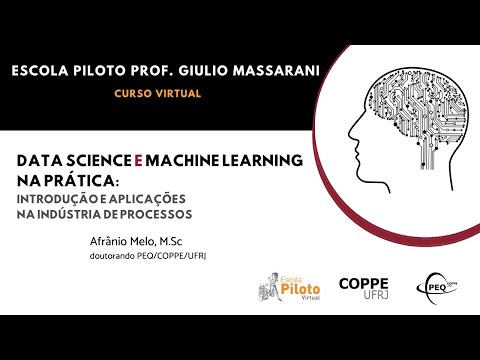

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo("1XS8Sw8jeuI")

Para a playlist do curso completo, clique [aqui](https://www.youtube.com/playlist?list=PLvr45Arc0UpzsRhzq3q4_KmZcm0utwvvB).

# Clusterização

* Na clusterização, o objetivo é agrupar observações similares em grupos chamados de *clusters*.

* É um procedimento análogo à classificação, porém não-supervisionado. Não há um conjunto de dados `y` com os rótulos de cada cluster: os algoritmos devem agrupar as observações apenas utilizando a estrutura da matriz de dados `X`.

Vamos utilizar a função [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) do `scikit-learn` de modo a gerar um conjunto de dados bidimensional simples para ver a metodologia em ação:

In [5]:
blob_centers = np.array([[ 0.2,  2.3],[-1.5 ,  2.3],
                         [-2.8,  1.8],[-2.8,  2.8],[-2.8,  1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = sklearn.datasets.make_blobs(n_samples=2000, centers=blob_centers,
                                   cluster_std=blob_std, random_state=0)

* Foram fornecidos como parâmetros à função `make_blobs` o número de observações e os centros e desvios-padrão de cada cluster. O número de clusters gerado foi 5, de acordo com os formatos das arrays `blob_centers` e `blob_std`.

* Apesar de a função retornar os rótulos verdadeiros `y`, eles não serão usados no treinamento dos modelos.

Visualizando os dados `X`:

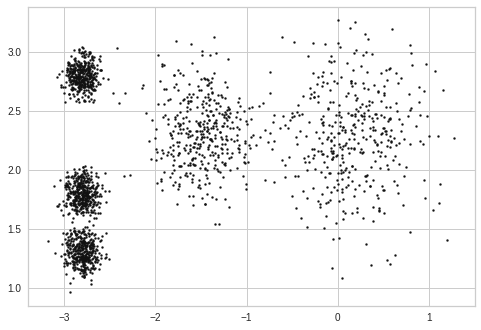

In [6]:
plt.scatter(X[:,0],X[:,1], s=4, c='k');

Os seis grupos são facilmente discriminados visualmente. 

Para discriminá-los computacionalmente, utilizaremos o modelo [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering), cujo funcionamento será detalhado mais adiante.

In [7]:
m = sklearn.cluster.KMeans(n_clusters = 5)
y_pred = m.fit_predict(X)

Perceba que foi necessário fornecer a priori o número de clusters. Essa é uma característica do modelo $k$-means.

Para verificar o desempenho do modelo, não é apropriado utilizar a função `accuracy_score`, como no problema de classificação, já que o rótulo de uma classe verdadeira no vetor `y` não necessariamente é o mesmo rótulo do cluster correspondente em `y_pred`.

Três métricas de clusterização muito utilizadas são:

- **homogeneidade**: maior quanto mais cada cluster contém apenas amostras de uma única classe verdadeira.
- **completude**: maior quanto mais amostras de cada classe verdadeira são atribuídas a um único cluster.
- **medida V**: a média harmônica entre homogeneidade e completude.

As três métricas variam entre 0 e 1 e podem ser calculadas de uma só vez com a função [homogeneity_completeness_v_measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_completeness_v_measure.html):

In [8]:
sklearn.metrics.homogeneity_completeness_v_measure(y, y_pred)

(0.9704930283682797, 0.9705254586158361, 0.970509243221138)

Essas métricas são interessantes, mas na maioria dos problemas práticos não podemos aplicá-las, já que os rótulos verdadeiros `y` não estão disponíveis. Nos casos em que estão disponíveis, o mais apropriado em geral é utilizar modelos de classificação.

# O modelo $k$-means

Para começarmos a entender o modelo, é interessante visualizar seu resultado em gráfico. A função `plot_decision_boundaries`, definida abaixo, aceita um modelo e um conjunto de dados e exibe as fronteiras de decisão de cada cluster:

In [9]:
# retiradas de github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=4)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=False, show_ylabels=False):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

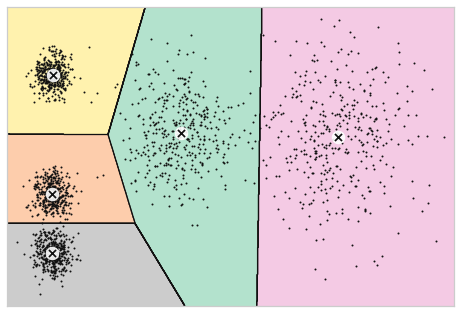

In [10]:
plot_decision_boundaries(m, X)

* A cada cluster $j$ é atribuído um ponto especial $\mu_j$ chamado de *centróide*, correspondente à média dos pontos contidos no cluster. Na figura, os centróides estão marcados com `x`.

* Gráficos em que o espaço é particionado em formatos geométricos disjuntos (sem sobreposições) são chamados de [tesselações](https://en.wikipedia.org/wiki/Tessellation). Em particular, o gráfico acima, em que cada partição $j$ é definida como o lugar geométrico dos pontos mais próximos a um certo ponto é chamado de [tesselação de Voronoi](https://en.wikipedia.org/wiki/Voronoi_diagram).

* No modelo $k$-means, as regiões que separam os $k$ clusters são definidas como as partições de Voronoi dos respectivos centróides $\mu_j$. 

* As fronteiras de decisão são lineares. 

* A maior fonte de erros parece estar na atribuição de observações de um cluster mais espalhado a um cluster mais compacto. De fato, como veremos, um dos pontos fracos do modelo $k$-means é não lidar bem com clusters de variâncias diferentes.

Podemos expressar os dados `X` em um novo espaço, em que as coordenadas de cada observação são as distâncias a cada centróide. Essa transformacão, conhecida como [quantização vetorial](https://en.wikipedia.org/wiki/Vector_quantization), é efetuada com o método `transform` do modelo:

In [11]:
T = m.transform(X)
T.shape

(2000, 5)

No caso acima, ocorreu aumento de dimensionalidade (já que há mais centróides do que dimensão original do problema, 2). Mas no caso de conjuntos com muitas variáveis, a transformação poderia ser usada para fins de redução de dimensionalidade.

Agora vamos apresentar o modelo formalmente e entender como funciona o cálculo dos centróides.

## $k$-means - Formalização

Enunciaremos as hipóteses relativas ao modelo:

* **Hipótese 1 (número de clusters)**: o número $k$ de clusters é conhecido a priori.

Seja um conjunto de dados $\mathbf{X} \in \mathbb{R}^{n\times m}$, em que cada linha corresponde a uma observação e cada coluna corresponde a uma variável. Sendo válida a Hipótese 1, o modelo pode definir os $k$ clusters dividindo o espaço $\mathbb{R}^{m}$ em $k$ regiões disjuntas associadas a cada um dos clusters. 

* **Hipótese 2 (caracterização dos clusters)**: um cluster $j$ pode ser caracterizado por meio de um parâmetro de centralidade.

Em particular, o parâmetro utilizado no $k$-means é o *centróide*, a média $\mu_j$ das observações contidas no cluster.

* **Hipótese 3 (composição dos clusters)**: cada cluster é composto pelas observações que se encontram mais próximas de seu centróide do que dos demais centróides.

Do ponto de vista geométrico, a hipótese 3 implica que os clusters devem ser [convexos](https://pt.wikipedia.org/wiki/Convexo) e [isotrópicos](https://en.wikipedia.org/wiki/Isotropy). Além do mais, como tudo o que importa para a atribuição de uma observação a um cluster é a distância para o centróide, o modelo pode não funcionar bem quando os clusters têm diferentes variâncias. Para uma demonstração prática do mal funcionamento do modelo no caso de violação das hipóteses, recomendo [esta página](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py).

Válidas as hipóteses, é possível definir uma função objetivo para minimização, denominada *inércia*, a soma dos quadrados das distâncias de cada observação ao centróide de seu cluster:

$$
\sum_{j=1}^k \sum_{i=1}^{n_j}||x_i-\mu_j||^2,
$$

em que $j = 1,...,k$ são os vários clusters e $i = 1, ..., {n_j}$ são as observações em um cluster $j$. As variáveis de decisão do espaço de otimização são os centróides $\mu_j$. 

Podemos acessar a inércia de um modelo do `scikit-learn` por meio do atributo `inertia_`:

In [12]:
m.inertia_

210.90929679398482

Um algoritmo muito usado para efetuar essa minimização de maneira eficiente é o [algoritmo de Lloyd](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm):

1. **ESPECIFIQUE** um número de clusters $k$.
2. **INICIALIZE** os centróides $\mu_j$ utilizando $k$ observações aleatórias.
3. **ATRIBUA** a cada observação o cluster de centróide mais próximo.
4. **RECALCULE** os centróides $\mu_j$ de acordo com os clusters recém-atribuídos.
5. **VOLTE** ao passo 3 e **REPITA** até convergência.

O algoritmo acima tem convergência garantida, apesar de facilmente resultar em mínimos locais que podem corresponder a soluções espúrias. Na prática, executa-se o algoritmo várias vezes com diferentes inicializações e escolhe-se a que resulta em menor inércia. No caso do `scikit-learn`, por default, o algoritmo é executado 10 vezes.

Pode-se mostrar que, geometricamente, a etapa 3 do algoritmo resulta nas partições de Voronoi anteriormente apresentadas em gráfico.

A maneira como se efetua a inicialização aleatória dos centróides, no passo 2, é um importante fator para convergência. [ARTHUR e VASSILVITSKII (2007)](https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf), por exemplo, propuseram o [$k$-Means++](https://en.wikipedia.org/wiki/K-means%2B%2B), em que força-se os centróides iniciais a resultarem afastados uns dos outros, aumentando a probabilidade de convergência para a solução ótima. Essa é a inicialização utilizada por default no `scikit-learn`.

Há diversas propostas para melhoria do algoritmo básico acima apresentado. [ELKAN (2003)](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) sugeriu uma metodologia em que muitos cálculos de distância são evitados, utilizando o conceito de [desigualdade triangular](https://pt.wikipedia.org/wiki/Desigualdade_triangular) e por meio do rastreamento de limites superiores e inferiores para distâncias entre observações e centróides. É o algoritmo utilizado por default no `scikit-learn`.

[HUANG (1997)](https://link.springer.com/article/10.1023/A:1009769707641) propôs o $k$-modes, designado para lidar com variáveis categóricas, por meio da definição dos clusters com base no número de categorias coincidentes entre as observações. [HUANG (1997)](https://grid.cs.gsu.edu/~wkim/index_files/papers/kprototype.pdf), em outro paper do mesmo ano, propôs ainda o $k$-prototypes, em que se combina o tratamento de variáveis contínuas e categóricas. Ambas as implementações não estão disponíveis no `scikit-learn`, mas podem ser aplicadas por meio da biblioteca [kmodes](https://pypi.org/project/kmodes/).

Outro avanço importante foi a proposta de [SCULLEY (2010)](https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf) para treino do $k$-means utilizando minilotes, de maneira parecida com o que é feito em redes neurais, o que acelera o algoritmo e possibilita o seu uso em conjuntos de dados que não caibam na memória. No `scikit-learn`, essa metodologia está disponível na classe [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).



## Selecionando o número de clusters

Duas técnicas serão apresentadas para decidir o número de clusters: os métodos [do cotovelo](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) e da [silhueta](https://en.wikipedia.org/wiki/Silhouette_(clustering)).

### Método do cotovelo

No método do cotovelo, a inércia é plotada em função do número de clusters, como abaixo:

In [13]:
def plot_inercia_per_k (X, k_list, ax = None):

    ax = ax or plt.gca()
    
    kmeans_per_k = [sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(X)
                    for k in k_list]

    inercias = [m.inertia_ for m in kmeans_per_k]

    ax.plot(k_list, inercias,ls='-',marker='*')

    ax.set_xlabel('$k$')
    ax.set_ylabel('inércia')
    
    return kmeans_per_k

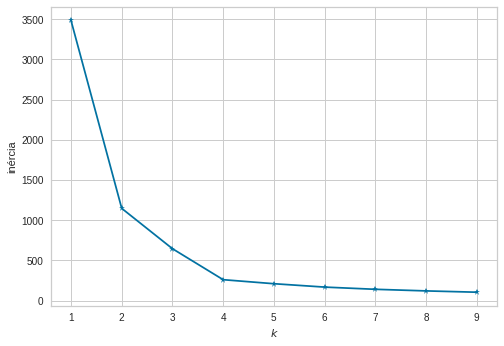

In [14]:
kmeans_per_k = plot_inercia_per_k(X, range(1,10))

Nota-se que há um ponto de inflexão em $k=4$, a partir do qual não há uma diminuição substancial da inércia conforme se aumenta $k$. Portanto, o valor de $k$ sugerido pelo método seria $4$. Não é a melhor solução (sabemos que o ótimo é $k=5$), apesar de levar a um resultado razoável: 

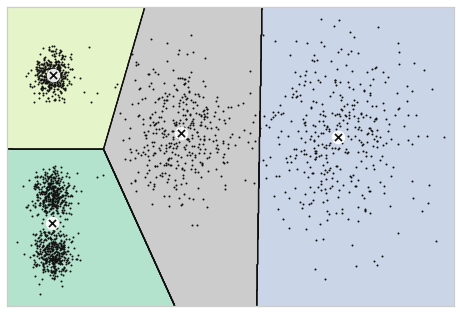

In [15]:
plot_decision_boundaries(kmeans_per_k[3], X)

O que ocorre é a interpretação dos dois clusters do canto inferior direito, que são bem próximos, como um cluster só.

Obs: o método do cotovelo também é usado em outros casos, como para selecionar o número de componentes principais no PCA, por exemplo.

### Método da silhueta

O coeficiente de silhueta de uma observação $x$ é definido como:

$$
s = \frac{b-a}{\max(a,b)},
$$

sendo:

* $a$ a distância média intra-cluster, ou seja, a média das distâncias de $x$ às observações do mesmo cluster;
* $b$ a distância média para o cluster mais próximo, ou seja, a média das distâncias de $x$ às observações do cluster mais próximo.

$s$ varia entre $-1$ e $1$:

* Um valor perto de $1$ sugere que $x$ está afastado dos demais clusters e contido em um cluster de amostras similares.
* Um valor perto de $0$ sugere que a amostra está próxima de uma fronteira entre clusters.
* Um valor perto de $-1$ sugere que a amostra está no cluster errado.

A função [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) retorna uma métrica definida como a média das silhuetas de todas as observações. Abaixo, visualizamos um gráfico dessa métrica em função do número de clusters:

In [16]:
def plot_silhueta_per_k(X, k_list, ax = None):

    ax = ax or plt.gca()
    
    kmeans_per_k = [sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(X)
                    for k in k_list]

    silhuetas = [sklearn.metrics.silhouette_score(X, m.labels_) for m in kmeans_per_k]

    ax.plot(k_list, silhuetas,ls='-',marker='*')

    ax.set_xlabel('$k$')
    ax.set_ylabel('silhueta média')
    
    return kmeans_per_k

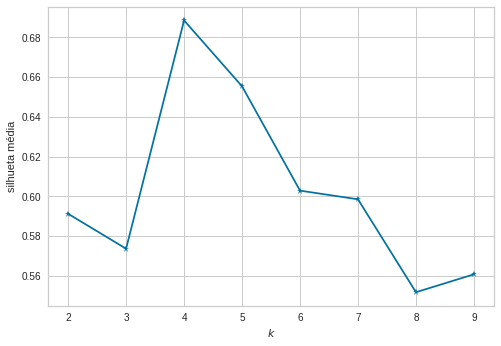

In [17]:
plot_silhueta_per_k(X,range(2,10));

O gráfico acima sugere, como o método do cotovelo, a escolha $k=4$. Apesar disso, fica claro que o valor $k=5$ também é bom e consideravelmente melhor do que os subsequentes.

Um gráfico muito mais informativo é o *diagrama de silhueta*. Para plotá-lo, utilizaremos a biblioteca [Yellowbrick](https://www.scikit-yb.org/), que contém rotinas para visualização de resultados de aprendizado de máquina. Em particular, utilizaremos o método [silhouette_visualizer](https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html#yellowbrick.cluster.silhouette.silhouette_visualizer) do módulo [yellowbrick.cluster](https://www.scikit-yb.org/en/latest/api/cluster/), que aceita um modelo e uma matriz de dados e plota o diagrama de silhueta:

In [18]:
def plot_silhueta(X, k_list):
        
    n_lines = int(np.ceil(len(k_list)/2))    
    
    fig, ax = plt.subplots(n_lines, 2, figsize = (16,4*n_lines))

    for i in range(len(k_list)):

        m = sklearn.cluster.KMeans(k_list[i])
        yellowbrick.cluster.silhouette_visualizer(m, X, show=False, ax=ax.ravel()[i]);

    fig.tight_layout()

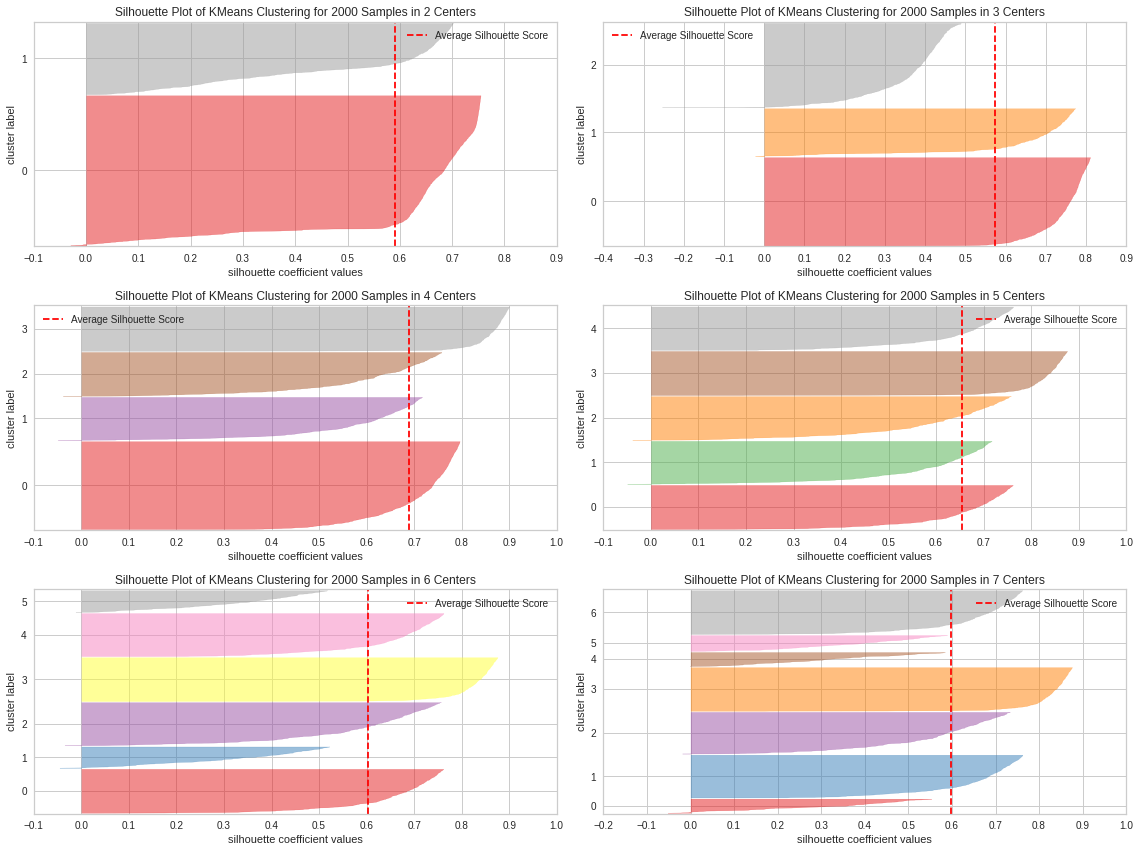

In [19]:
plot_silhueta(X, [2,3,4,5,6,7])

* Nos gráficos acima, cada figura em forma de faca corresponde a um cluster e contém os coeficientes de silhueta de suas observações.

* A altura de cada figura indica o tamanho (quantidade de observações) de cada cluster.

* Quanto mais comprida for uma figura, mais os coeficientes de silhueta do cluster correspondente aproximam-se de $1$, o valor ótimo.

* A análise dos gráficos indicaria que $k=4$ ou $5$ seriam escolhas razoáveis, já que em todos os clusters as figuras estendem-se além da linha vertical que representa a silhueta média. 

* Na prática, a escolha por $k=5$ poderia ser feita de modo a gerar clusters de tamanhos semelhantes.

Agora vamos analisar uma aplicação prática de clusterização, a segmentação de mercado.

# Segmentação de mercado

[Segmentação de mercado](https://pt.wikipedia.org/wiki/Segmenta%C3%A7%C3%A3o_de_mercado) é o processo de identificar, em um conjunto heterogêneo de consumidores, grupos com características e comportamentos semelhantes. É uma importante ferramenta para entender o mercado e direcionar ações específicas para cada tipo de cliente.

Existem várias metodologias para efetuar a segmentação. Uma muito conhecida é a [RFM](https://en.wikipedia.org/wiki/RFM_(market_research)), que visa dividir grupos de acordo com os seguintes critérios:

* **Recency**: quando a última compra foi efetuada;

* **Frequency**: com que frequência compras são efetuadas;

* **Monetary Value**: quanto o cliente costuma gastar.

O [conjunto de dados](https://www.kaggle.com/carrie1/ecommerce-data) utilizado refere-se a transações efetuadas entre 01/12/2010 e 09/12/2011 por uma loja online de varejo do setor de presentes baseada no Reino Unido. 

A análise aqui efetuada foi baseada [neste curso](https://www.datacamp.com/courses/customer-segmentation-in-python), em particular [nestes](https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter2.pdf), [nestes](https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter3.pdf) e [nestes](https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter4.pdf) slides. Para um estudo mais aprofundado aplicado ao mesmo conjunto de dados, recomendo [este paper](https://link.springer.com/article/10.1057/dbm.2012.17) ou [este notebook](https://www.kaggle.com/fabiendaniel/customer-segmentation).

## Importando e analisando dados

Utilizando a função `read_csv` para ler os dados:

In [20]:
df_raw = pd.read_csv('/kaggle/input/ecommerce-data/data.csv',
                     encoding="ISO-8859-1", low_memory=False, 
                     parse_dates=["InvoiceDate"])

Visualizando o DataFrame:

In [21]:
df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Descrições das colunas, de acordo com o [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail):

* **InvoiceNo**: Número da fatura. Nominal, um número integral de 6 dígitos atribuído exclusivamente a cada transação. Se este código começar com a letra 'c', isso indica um cancelamento.
* **StockCode**: código do produto (item). Nominal, um número integral de 5 dígitos atribuído exclusivamente a cada produto distinto.
* **Description**: Nome do produto (item). Nominal.
* **Quantity**: as quantidades de cada produto (item) por transação. Numérico.
* **InvoiceDate**: Data e hora do inventário. Numérico, o dia e a hora em que cada transação foi gerada.
* **UnitPrice**: preço unitário. Numérico, preço do produto por unidade em libras esterlinas.
* **CustomerID**: Número do cliente. Nominal, um número integral de 5 dígitos atribuído exclusivamente a cada cliente.
* **Contry**: nome do país. Nominal, o nome do país onde cada cliente reside.

Analisando os tipos das variáveis no DataFrame:

In [22]:
df_raw.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Analisando o padrão de dados faltantes:

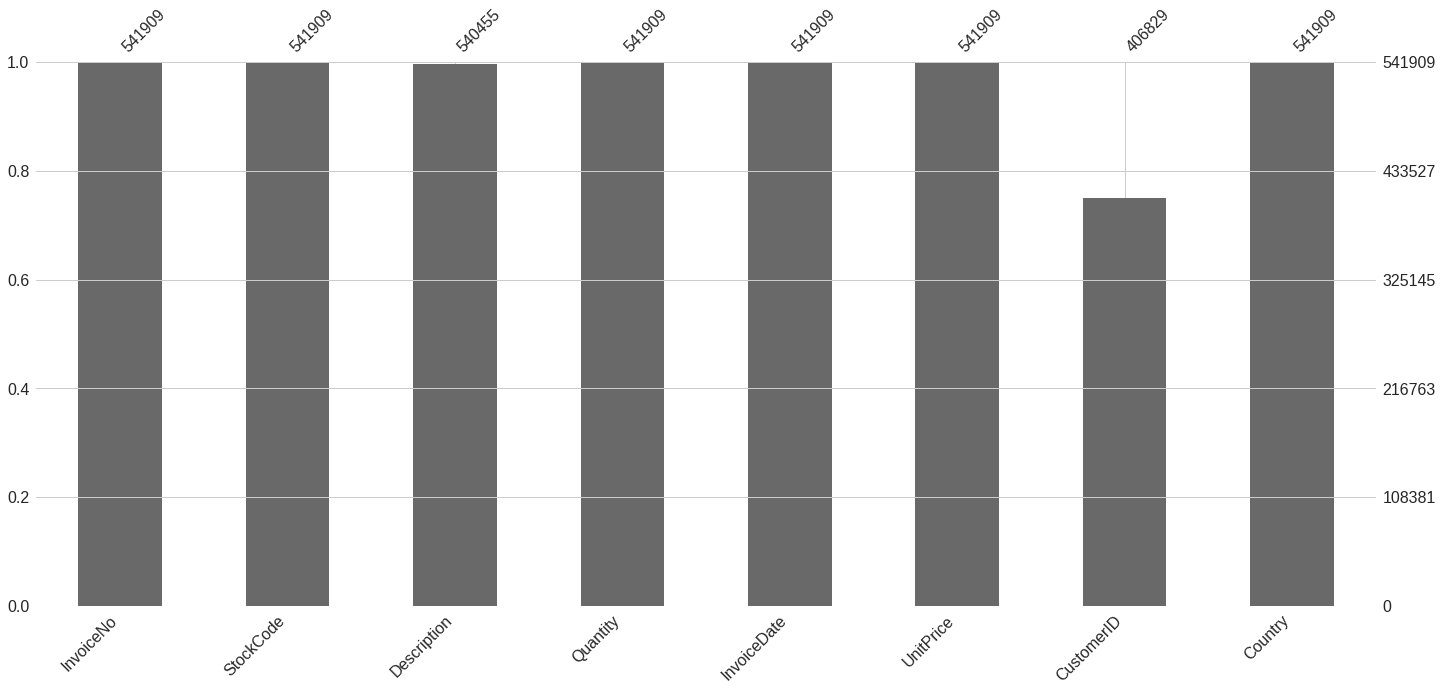

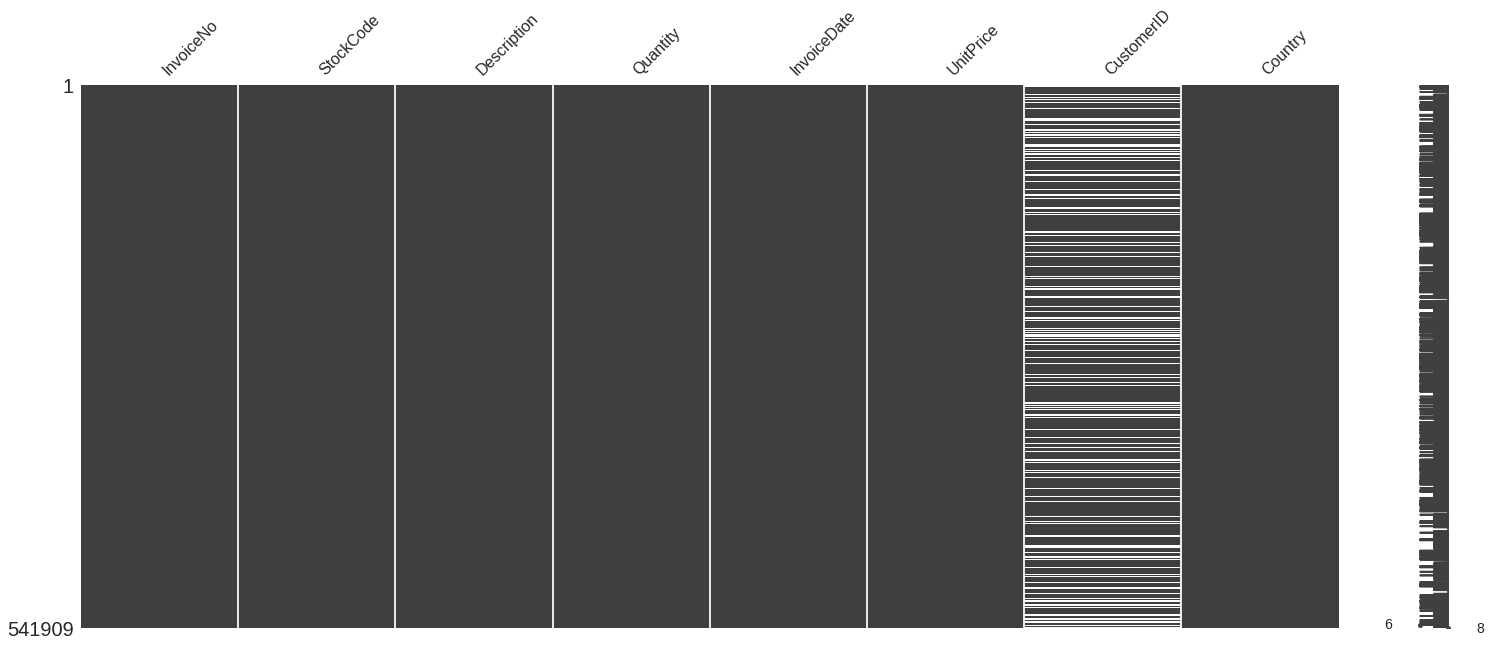

In [23]:
missingno.bar(df_raw)
missingno.matrix(df_raw);

Percebe-se que há muitas compras em que não se identificam os consumidores.

## Pré-processamento dos dados

Podemos retirar as observações em que os consumidores não são identificados:

In [24]:
df_tmp = df_raw.dropna(axis = 0, subset = ['CustomerID'])

É útil calcular a soma total gasta em cada compra:

In [25]:
df_tmp["TotalSum"] = df_tmp["Quantity"] * df_tmp["UnitPrice"]

Na célula abaixo, os dados são transformados para o espaço RFM:  

In [26]:
snapshot_date = max(df_tmp.InvoiceDate) + datetime.timedelta(days=1)

df_rfm_raw = df_tmp.groupby(['CustomerID']).agg({
      'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
      'InvoiceNo': 'count',
      'TotalSum': 'sum'})

df_rfm_raw.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

df_rfm_raw

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


Poderíamos aplicar a clusterização neste momento, mas as distribuições das variáveis são muito [assimétricas](https://pt.wikipedia.org/wiki/Assimetria_(estat%C3%ADstica)), como mostrado nos gráficos abaixo:

Recency           1.249665
Frequency        18.153735
MonetaryValue    21.705287
dtype: float64


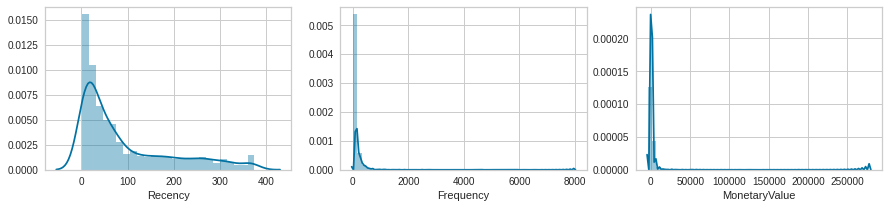

In [27]:
print(df_rfm_raw.skew())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

for i in range(3):
    sns.distplot(df_rfm_raw.iloc[:,i], ax=ax[i])

Acima da figura estão impressos os valores de [skew](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.skew.html) de cada variável, uma medida de assimetria; quanto mais distantes de zero, mais assimétricas são as distribuições.

Podemos aplicar [transformações de potência](https://en.wikipedia.org/wiki/Power_transform) para aumentar a simetria das distribuições, tornando-as mais "gaussianas". Para isso, utilizaremos a função [power_transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html) do módulo [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing):

In [28]:
arr_rfm = sklearn.preprocessing.power_transform(df_rfm_raw)

df_rfm = pd.DataFrame(arr_rfm,
                      index = df_rfm_raw.index,
                      columns = df_rfm_raw.columns)

Visualizando as distribuições resultantes:

Recency         -0.057833
Frequency       -0.000221
MonetaryValue    5.100041
dtype: float64


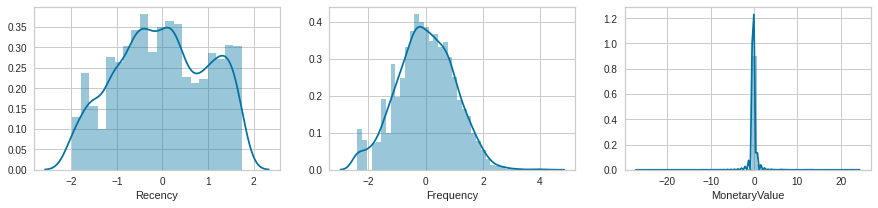

In [29]:
print(df_rfm.skew())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

for i in range(3):
    sns.distplot(df_rfm.iloc[:,i], ax=ax[i])

As duas primeiras distribuições parecem razoáveis, mas a última ainda tem um valor de skew alto. Podemos tentar outra transformação, aplicando a raiz cúbica:

In [30]:
df_rfm['MonetaryValue'] = np.cbrt(df_rfm_raw['MonetaryValue'])

Checando:

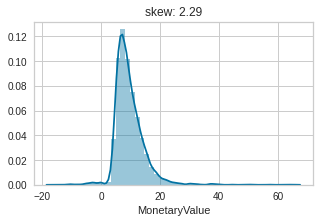

In [31]:
fig, ax = plt.subplots(figsize=(5,3))

sns.distplot(df_rfm.iloc[:,i],ax=ax)
plt.title(f'skew: {df_rfm.skew()[-1]:.3}');

Parece bem melhor!

Como última etapa de pré-processamento, normalizemos as variáveis para que todas tenham média $0$ e desvio-padrão $1$:

In [32]:
df_rfm = (df_rfm-df_rfm.mean())/df_rfm.std()

Essa normalização faz com que as variáveis se distribuam em torno do mesmo ponto e com o mesmo grau de espalhamento, o que pode ajudar bastante a aplicação do algoritmo.

## Modelagem

O primeiro passo é calcular as curvas de inércia e silhueta em função de $k$ de modo a tentar encontrar uma pista para um bom número de clusters:

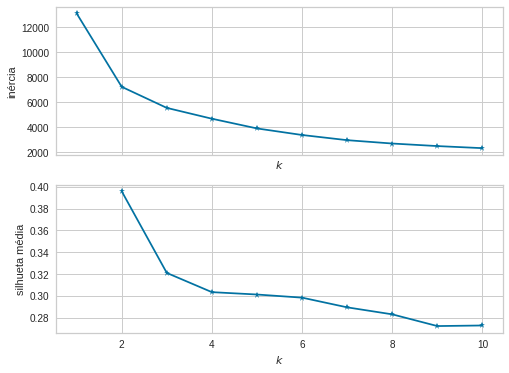

In [33]:
fig, ax = plt.subplots(2,1, figsize = (8,6), sharex=True)

kmeans_per_k = plot_inercia_per_k(df_rfm, range(1,11), ax=ax[0])
plot_silhueta_per_k(df_rfm, range(2,11), ax=ax[1]);

As curvas não são muito informativas. Em particular, na curva de inércia, fora o ponto $k=2$, as demais inflexões são muito sutis. Isso dificulta a escolha visual em que se baseia o método do cotovelo.

Checando os diagramas de silhueta:

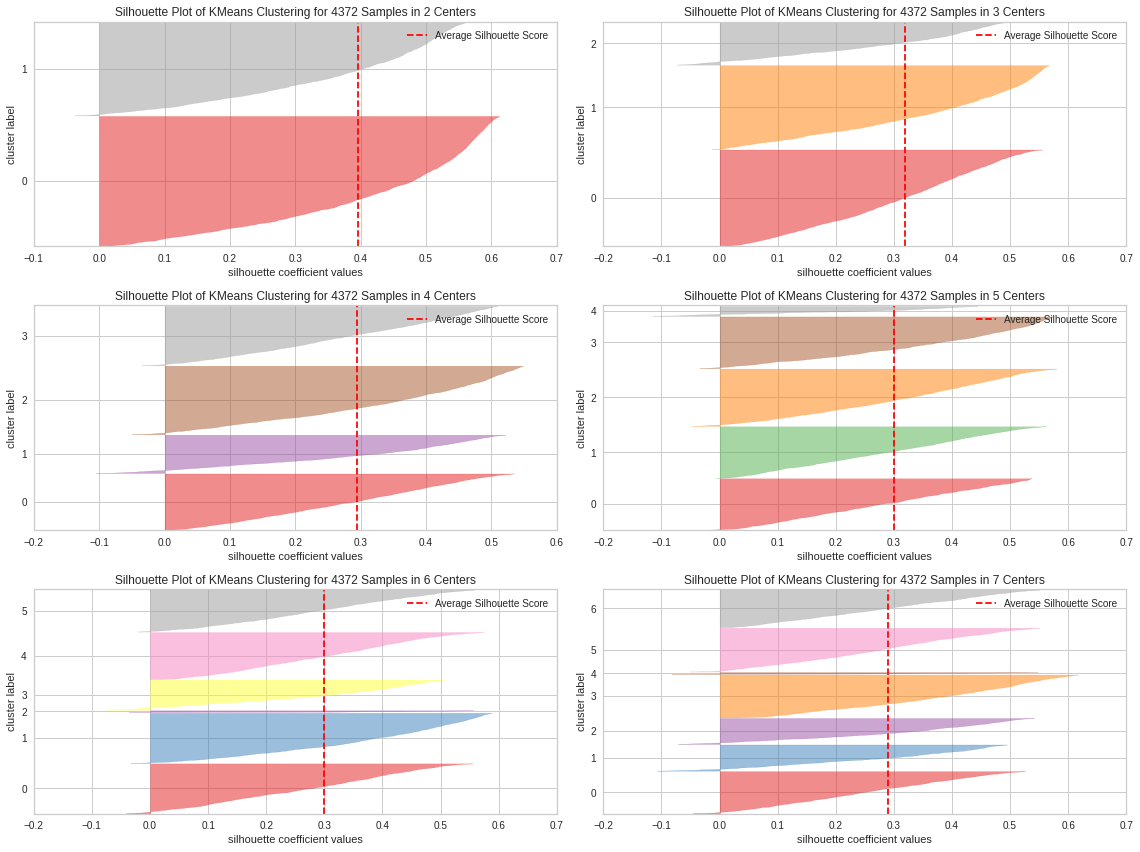

In [34]:
plot_silhueta(df_rfm, [2,3,4,5,6,7])

Os diagramas de silhueta são bem mais informativos. Todas as configurações resultam em clusters com boa quantidade de silhuetas acima da média (que não é muito alta, entretanto). A escolha de 4 clusters parece ser particularmente adequada por resultar em conjuntos de tamanhos semelhantes.

É possível visualizar o espaço RFM em gráficos 3d. Abaixo são comparadas duas escolhas, $k=3$ e $k=4$:

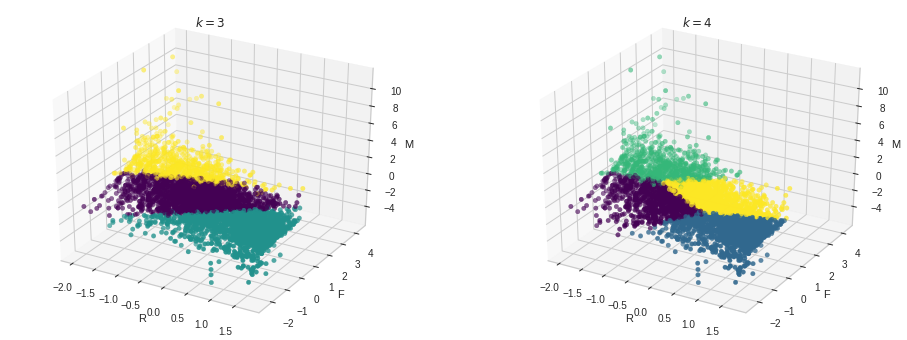

In [35]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'3d'}, figsize=(16,6))

k = [2,3]

for i in range(len(k)):

    ax[i].scatter(df_rfm.iloc[:,0], df_rfm.iloc[:,1], df_rfm.iloc[:,2],
                  c=kmeans_per_k[k[i]].labels_, cmap='viridis')

    ax[i].set_title(f'$k={k[i]+1}$')
    
    ax[i].set_xlabel('R')
    ax[i].set_ylabel('F')
    ax[i].set_zlabel('M')

Fica claro dos gráficos anteriores que os clusters obtidos não refletem uma estrutura de agrupamento intrínseca dos dados. Isso não é necessariamente um problema: se o modelo conseguir dividir o espaço em clusters de clientes com características específicas, o resultado pode ser satisfatório.

Para entender melhor as diferenças entre os clusters, é útil traçarmos um [snake plot](https://www.marketingprofs.com/tutorials/snakeplot.asp), em que as médias de recência, frequência e valor monetário de cada um dos clusters são interligados por segmentos de reta:

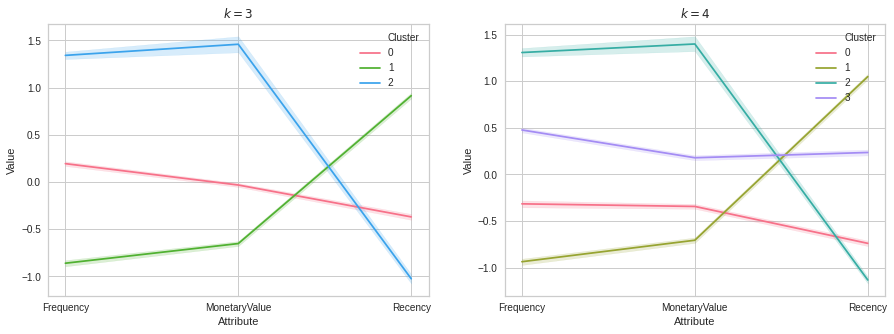

In [36]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

k = [2,3]

for i in range(len(k)):
    
    df_tmp = copy.deepcopy(df_rfm)
    df_tmp['ID'] = df_rfm.index
    df_tmp['Cluster'] = kmeans_per_k[k[i]].labels_
    df_tmp_melt = pd.melt(df_tmp.reset_index(),
                          id_vars=['ID', 'Cluster'],
                          value_vars=['Recency','Frequency','MonetaryValue'],
                          var_name='Attribute',
                          value_name='Value')

    sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_tmp_melt, 
                 ax=ax[i], palette = sns.color_palette("husl", k[i]+1))
    
    ax[i].set_title(f'$k={k[i]+1}$')

Os sombreados definem intervalos de confiança de 95%.

Do primeiro gráfico acima (em que $k=3$), percebe-se que os clusters representam três tipos distintos de clientes:

* $0$: aparecem com média frequência, não gastam muito e compraram há não muito tempo.
* $1$: aparecem com baixa frequência, gastam pouco e compraram há muito tempo. Em tese, é o cluster de clientes que agregam menos valor ao negócio.
* $2$: aparecem com bastante frequência, gastam muito e compraram há pouco tempo. Em tese, é o cluster de clientes mais valiosos.

A introdução de mais um cluster no modelo divide o cluster $0$ do gráfico da esquerda em dois, os clusters $0$ e $3$ no gráfico da direita. A escolha por efetuar ou não essa divisão adicional pode ser uma decisão estratégica da companhia, baseada nas ações que serão tomadas a partir da informação fornecida pelo modelo.

Agora vamos iniciar nosso segundo estudo de caso, a identificação de modos de operação em um reator químico.

# CSTR

O [reator tanque agitado contínuo](https://en.wikipedia.org/wiki/Continuous_stirred-tank_reactor) (CSTR, da sigla em inglês), esquematizado a seguir, é um dos modelos de reator mais utilizados na engenharia química.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/be/Agitated_vessel.svg" width="300" height="300"/>

Na modelagem de reatores CSTR, uma hipótese muito utilizada é a da [mistura perfeita](https://en.wikipedia.org/wiki/Perfect_mixing), em que considera-se que cada elemento de fluido da entrada se mistura instantânea e perfeitamente ao conteúdo uniforme do reator. Nesse caso, o modelo é chamado de *CSTR ideal*. 

A partir da relação básica de balanço:

$$\verb! Acumulo = Entrada - Saida + Geracao!,$$

as seguintes equações diferenciais ordinárias podem ser obtidas para um CSTR ideal em que ocorra a reação irreversível $A \rightarrow B$:

* **Balanço de massa global**:

$$\frac{dV}{dt} = F_i - F$$

* **Balanço de massa por componente**:

$$ \frac{dVC_A}{dt} = F_i C_{Ai} - FC_A - VrC_A $$

* **Balanço de energia**:

$$ \frac{dVT}{dt} = F_i T_i - FT - \frac{\Delta H}{\rho c_p} V_r C_A - \frac{UA}{\rho c_p} (T-T_j) $$

* **Balanço de energia na jaqueta de resfriamento**:

$$ \frac{dT_j}{dt} = \frac{F_j (T_{ji}-T_j)}{V_j} + \frac{UA}{\rho_j c_{pj} V_j} (T-T_j) $$

O modelo fica completo com a adição da [taxa de reação](https://en.wikipedia.org/wiki/Reaction_rate):

* **Taxa de reação ([equação de Arrhenius](https://en.wikipedia.org/wiki/Arrhenius_equation))**:

$$ r = r_0 e^{-E/RT}$$

Além do mais, podem ser adicionadas equações de [controle](https://en.wikipedia.org/wiki/Control_system) (no caso, do tipo [proporcional](https://en.wikipedia.org/wiki/Proportional_control)):

* **Equações de controle**:

$$ F = F_{set} +P_V (V_{set}-V)$$

$$ F_j = F_{j, set} +P_T (T_{set}-T) $$

Seguem as descrições das variáveis:

* **Variáveis de estado**: 
    * $V$: volume de reação;
    * $C_A$: concentração do reagente $A$ no reator;
    * $T$: temperatura do reator;
    * $T_j$: temperatura da jaqueta.
* **Variáveis de entrada**: 
    * $F_i$: vazão de entrada do reator;
    * $C_{Ai}$: concentração de $A$ na entrada do reator;
    * $T_i$: temperatura da entrada do reator;
    * $T_{ji}$: temperatura de entrada da jaqueta.
* **Variáveis manipuladas**: 
    * $F$: vazão de saída do reator;
    * $F_{j}$: vazão de água de resfriamento da jaqueta.
* **Variáveis controladas**: $V$ e $T$.
* **Parâmetros**: 
    * $r_0$: fator pré-exponencial da equação de Arrhenius;
    * $E$: energia de ativação da equação de Arrhenius;
    * $\Delta H$: entalpia de reação;
    * $\rho$: densidade da mistura; 
    * $c_p$: capacidade calorífica da mistura; 
    * $U$: coeficiente global de transferência de calor;
    * $A$: área de troca térmica;
    * $V_j$: volume da jaqueta; 
    * $\rho_j$: densidade do fluido de resfriamento;
    * $c_{pj}$ : capacidade calorífica do fluido de resfriamento;
    * $P_V$: ganho do controlador de vazão de saída;
    * $P_T$: ganho do controlador de vazão de fluido de resfriamento.
    
O modelo acima é baseado no estudo de caso proposto por [FEITAL *et al.* (2013)](https://aiche.onlinelibrary.wiley.com/doi/abs/10.1002/aic.13953).
   
## Implementação
    
Como os resultados do modelo são totalmente determinísticos, é útil adicionar ruído de medição para tornar os dados mais realistas. Isso será feito pela função `create_df_with_noise`, definida abaixo, que aceita uma matriz de dados no argumento `array`, a fração da variabilidade total que vai corresponder à variabilidade do ruído no argumento `noise_frac` e o índice máximo para o cálculo dessa fração no argumento `max_index_for_noise`:

In [37]:
def create_df_with_noise (array, noise_frac,
                          max_index_for_noise, 
                          columns = None,
                          start = '2020-01-01 00:00:00', 
                          freq = '2T'):
    
    df = pd.DataFrame(array, columns = columns)

    sigma_noise = noise_frac*(np.amax(array[:max_index_for_noise,:], 
                                      axis=0)-
                              np.amin(array[:max_index_for_noise,:], 
                                      axis=0))

    for i in range(df.shape[1]):
        df.iloc[:,i] = (df.iloc[:,i] + 
                        sigma_noise[i]*np.random.randn(df.shape[0]))
        
        
    df.index = pd.date_range(start = start, 
                             periods = df.shape[0],
                             freq=freq)

    return df

O modelo CSTR está implementado na classe `CSTR`, definida a seguir.

In [38]:
class CSTR():
    
    def __init__ (self, Vj = 3.85, rho = 50.0, rhoj = 62.3, k0 = 7.08e10,
                   E = 30000.0, R = 1.99, DH = -30000.0,
                   Cp = 0.75, U = 150.0, A = 250.0, Cpj = 1.0,
                   nk =  2880, t_sampling = 2, Pv =  -10.0, Pt = -4.,
                   mu_u = {'Fi': 40,'Cai': 0.5, 'Ti': 530, 'Tji': 530}, 
                   sigma_u = {'Fi': 1.5, 'Cai': 2e-2, 'Ti': 1, 'Tji': 1},
                   ws_u = 100, sp = {'Vs': 48, 'Fs': 40, 'Fjs': 49.9}, 
                   T_guesses = [500,600,700], ee0 = 2):
        '''
        Construtor: inicializa o objeto, deixando-o pronto para a execução 
                    com os métodos `run` ou `simulate`.
                    
        Para as unidades dos argumentos, consulte doi.org/10.1002/aic.13953
        '''
        
        # parâmetros do modelo:
        
        # volumétricos
        self.Vj, self.rho, self.rhoj = Vj, rho, rhoj 

        # de reação
        self.k0, self.E, self.R, self.DH = k0, E, R, DH

        # de energia
        self.Cp, self.U, self.A, self.Cpj  = Cp, U, A, Cpj
                        
        # cálculo da constante de reação
        self.k_fun = lambda k0, T: k0*np.exp(-self.E/(self.R*T))
        
        # parâmetros da simulação:
        
        # número de observações
        self.nk = nk

        # instantes de amostragem
        self.t = np.arange(0,t_sampling*(nk)/60,t_sampling/60)
        
        # ganhos do controlador
        self.Pv, self.Pt = Pv, Pt
        
        # variáveis:
        
        # variáveis de estado (x)
        self.x_labels = ['V','Ca','T','Tj']
        self.x_units  = ['ft$^3$','mol/ft$^3$','R','R']
        
        # variáveis de entrada (u)
        self.u_labels = ['Fi','Cai','Ti','Tji']
        self.u_units  = ['ft$^3$/h','mol/ft$^3$','R','R']
        
        # variáveis manipuladas (m)
        self.m_labels = ['F','Fj']
        self.m_units  = ['ft$^3$/h','ft$^3$/h']

        # definindo variáveis u, x e m
            
        u_labels = ['Fi', 'Cai', 'Ti', 'Tji']
        x_labels = ['V', 'Ca', 'T', 'Tj']
        m_labels = ['F', 'Fj']

        # gerando variáveis de entrada com perturbações de processo
        
        mu_u = [mu_u.get(k) for k in u_labels if k in mu_u]
        sigma_u = [sigma_u.get(k) for k in u_labels if k in sigma_u]

        self.set_input(mu_u, sigma_u, ws_u)

        # definindo set-points
        
        [setattr(self, name, value) for name, value in sp.items()]
        
        # calculando estados estacionários
        
        self.calc_EE(T_guesses)
        
        # definindo set-point da temperatura

        self.Ts = self.EE[ee0,1]
        
        # definindo condições iniciais
        
        V0   = self.Vs
        Ca0  = self.EE[ee0,0]
        T0   = self.EE[ee0,1]
        Tj0  = self.EE[ee0,2]

        F0  = self.Fs
        Fj0 = self.Fjs

        self.set_initial_conditions (V0, Ca0, T0, Tj0, F0, Fj0)
        
    #########################

    def set_input (self, u_ref, sigma, WS):
        '''
        Gera variáveis de entrada com variabilidade que simula 
        perturbações de processo.
        '''        
        
        from sklearn.preprocessing import scale
        
        self.u = np.zeros((self.nk, len(u_ref)))
        self.mu_u = np.zeros((self.nk, len(u_ref)))
                 
        for i in range(len(u_ref)):

            u = np.random.randn(self.nk+WS-1)
            u = pd.Series(u).rolling(window=WS).mean().iloc[WS-1:].values
            self.mu_u[:,i] = u_ref[i]
            self.u[:,i] = self.mu_u[:,i]+sigma[i]*scale(u)
            
    #########################
    
    def set_set_points (self,Vs,Ts,Fs,Fjs):
        '''
        Atribuição dos set-points.
        '''  
        
        self.Vs, self.Ts, = Vs, Ts
        self.Fs, self.Fjs = Fs, Fjs

    #########################
    
    def calc_EE (self, T_guesses): 
        '''
        Cálculo dos estados estacionários.
        '''  
        
        Vo = self.Vs
        Fo = self.Fs
        Fjo = self.Fjs
        
        Cao = self.mu_u[0,1]
        To  = self.mu_u[0,2]
        Tjo = self.mu_u[0,3]
        
        def F1(T):
            k = self.k_fun(self.k0,T)
            return -self.DH*k*Fo*Cao/(Fo/Vo + k)

        def F2(T):
            Tj  = (Fjo*Tjo/self.Vj + 
                   self.U*self.A*T/(self.rhoj*self.Vj*self.Cpj))/(Fjo/self.Vj+\
                                    self.U*self.A/(self.rhoj*self.Vj*self.Cpj))
            return Fo*self.rho*self.Cp*(T - To) + self.U*self.A*(T - Tj)
        
        def F12(T):
            k = self.k_fun(self.k0,T)
            Tj  = (Fjo*Tjo/self.Vj + 
                   self.U*self.A*T/(self.rhoj*self.Vj*self.Cpj))/(Fjo/self.Vj+\
                                    self.U*self.A/(self.rhoj*self.Vj*self.Cpj))
            return Fo*self.rho*self.Cp*(T - To) + self.U*self.A*(T - Tj) + \
                   self.DH*k*Fo*Cao/(Fo/Vo + k)
        
        def Ca(T):
            k = self.k_fun(self.k0,T)
            return Cao/(1 + Vo*k/Fo)

        def Tjac(T):
            tjac=(Fjo*Tjo/self.Vj + 
                  self.U*self.A*T/(self.rhoj*self.Vj*self.Cpj))/(Fjo/self.Vj+\
                                   self.U*self.A/(self.rhoj*self.Vj*self.Cpj))

            return tjac

        self.t_ee = []; self.f_ee = []; 
        self.g_ee = []; self.ca_ee = []; 
        self.tj_ee = []

        for T in np.arange(min(T_guesses),max(T_guesses)):
            self.t_ee.append(T)
            self.f_ee.append(F1(T))
            self.g_ee.append(F2(T))
            self.ca_ee.append(Ca(T))
            self.tj_ee.append(Tjac(T))

        T1 = scipy.optimize.fsolve(F12,T_guesses[0])
        Ca1 = Ca(T1);
        Tj1 = Tjac(T1)
        
        T2 = scipy.optimize.fsolve(F12,T_guesses[1])
        Ca2 = Ca(T2)
        Tj2 = Tjac(T2)
        
        T3 = scipy.optimize.fsolve(F12,T_guesses[2])
        Ca3 = Ca(T3)
        Tj3 = Tjac(T3)

        self.EE  = np.array([[Ca1[0], T1[0], Tj1[0]], 
                             [Ca2[0], T2[0], Tj2[0]], 
                             [Ca3[0], T3[0], Tj3[0]]])
                
    #########################
     
    def model (self,t,x,u,m):
        '''
        Sistema de equações diferenciais que constitui
        o modelo dinâmico propriamente dito do processo.
        '''  
        
        # variáveis de estado
        V, Ca, T, Tj = x

        # variáveis de entrada  
        Fi, Cai, Ti, Tji  = u

        # variáveis manipuladas
        F, Fj  = m

        k = self.k_fun(self.k0,T)

        dx    = np.zeros(4)
        dx[0] = Fi - F
        dVC   = Fi*Cai - F*Ca - V*k*Ca
        dx[1] = (dVC - Ca*dx[0])/V
        dVT   = Fi*Ti - F*T + \
                V*k*Ca*(-self.DH)/(self.rho*self.Cp) - \
                self.U*self.A*(T-Tj)/(self.rho*self.Cp)
        dx[2] = (dVT - T*dx[0])/V
        dx[3] = (Tji-Tj)*Fj/self.Vj + \
                self.U*self.A*(T-Tj)/(self.Vj*self.rhoj*self.Cpj)

        return dx  

    #########################  
    
    def control (self,V,T):
        '''
        Atuação de controle proporcional.
        '''  

        # estruturas de controle
        F  = self.Fs  + self.Pv*(self.Vs - V)
        Fj = self.Fjs + self.Pt*(self.Ts - T) 

        # restrições
        if Fj > 100: Fj = 100
        if Fj <   0: Fj =   0
        if F  > 100: F  = 100
        if F  <   0: F  =   0

        return np.array([F, Fj])
    
    #########################
    
    def set_initial_conditions (self, V0, Ca0, T0, Tj0, F0, Fj0):
        '''
        Atribuição de condições iniciais.
        '''  
        
        self.x0 = np.array([V0, Ca0, T0, Tj0])
        self.m0 = np.array([F0, Fj0])
        
    #########################
    
    def simulate (self, control = True, sp = None, devs = None):
        '''
        Integração das equações diferenciais que compõem o modelo.
        ''' 
        
        # matriz que armazenará as variáveis de estado
        self.x = np.zeros((self.nk,self.x0.shape[0]))
        
        # matriz que armazenará as variáveis manipuladas
        self.m = np.zeros((self.nk,self.m0.shape[0]))

        # definindo estado inicial
        self.x[0,:] = self.x0
        self.m[0,:] = self.m0
        
        # matriz que armazenará os valores nominais de todas as variáveis
        self.nom = np.zeros((self.nk, 
                             self.x.shape[1]+self.u.shape[1]+self.m.shape[1]))
        self.nom[0,:] = np.hstack((self.x0, self.mu_u[0,:], self.m0))

        # armazenando set-points                
        if sp is not None:
            self.sp = sp
        else:
            self.sp = np.zeros(self.nk)+2

        # armazenando valores normais das variáveis que terão desvio        
        if devs is not None:
            normais = {}
            for key, value in devs.items():
                normais[key] = getattr(self, key)
                
        # loop de integração
                    
        for j in range(1,self.nk):
            
            # introduzindo desvios nas variáveis pertinentes            
            if devs is not None:
                for key, value in devs.items():
                    setattr(self, key, normais[key]*(1+value[j]))

            # integrando!            
            res = scipy.integrate.solve_ivp(lambda t,x:self.model(t,
                                                                  x,
                                                                  self.u[j,:],
                                                                  self.m[j-1,:]
                                                                  ),
                                            [self.t[j-1],self.t[j]],
                                            self.x[j-1,:],
                                            rtol=1e-12,
                                            atol=1e-12) 
            self.x[j,:] = res.y[:,-1]
            
            if control:
            
                # controlando!
                self.m[j,:] = self.control(*self.x[j,[0,2]])
                
                # setando o set-point de Ts para definir o EE
                self.Ts = self.EE[int(self.sp[j]),1] 
                self.nom[j,:] =  np.array([self.x0[0]] +
                                          self.EE[int(self.sp[j]),:].tolist() +
                                          self.mu_u[j,:].tolist() + 
                                          [self.Fs]+[self.Fjs])
                    
            else:
                
                self.m[j,:] = self.m[j-1,:]

    #########################
    
    def run (self, ee_sp = None, 
             meas_noise_frac = 0.1, max_index_noise_frac = -1, 
             faulty = False, faulty_variable = 'k0',
             devs_fault = None, index_fault = None):
        '''
        Integração do modelo, chamando o método `simulate` e retornando
        um DataFrame com os dados de processo.
        ''' 
        
        if faulty:
            if devs_fault is None:
                devs_fault = np.zeros(self.nk)
                j_f0 = int(self.nk/2)
                self.index_fault = j_f0
                j_fn = self.nk
                for j in range(j_f0, j_fn):
                    if j >= j_f0 and j<=j_fn:
                        devs_fault[j] = (j_f0-j)/j_fn
                    else:
                        devs_fault[j] = (j_f0-j_fn)/j_fn 
            else:
                self.index_fault = index_fault
            self.simulate(sp= ee_sp, devs = {faulty_variable:devs_fault})
        else:
            self.simulate(sp = ee_sp)

        array = np.hstack((self.x, self.u, self.m))

        df = create_df_with_noise(array, meas_noise_frac, 
                                  max_index_noise_frac,
                                  columns = (self.x_labels + 
                                             self.u_labels + 
                                             self.m_labels))

        return df
        
    #########################        
              
    def plot (self, kind = 'x'):
        '''
        Plot das variáveis $x$, $u$ ou $m$.
        ''' 
        
        if kind == 'x':
            y = self.x
            y_labels = self.x_labels
            y_units  = self.x_units
            nom = self.nom[2:,:4]
            title='State'
        elif kind == 'u':
            y = self.u
            y_labels = self.u_labels
            y_units  = self.u_units
            title='Input'
        elif kind == 'm':
            y = self.m
            y_labels = self.m_labels
            y_units  = self.m_units
            nom = self.nom[2:,8:]
            title='Manipulated'
            
        fig, ax = plt.subplots(1, y.shape[1], figsize=(15,4))
            
        for i in range(y.shape[1]):
            ax.ravel()[i].plot(self.t, y[:,i])
            ax.ravel()[i].set_title(y_labels[i]+' ('+y_units[i]+')')
            if kind == 'x' or kind == 'm':
                ax.ravel()[i].plot(self.t[2:],
                                   nom[:,i],':k')
                
        fig.suptitle(title+' Variables x time (h) ');
        
        fig.tight_layout()
        
    #########################    
    
    def plot_van_heerden (self, ax = None):
        '''
        Plot do diagrama de van Heerden.
        ''' 
        
        ax = ax or plt.gca()
        ax.plot(self.t_ee,self.f_ee,label='Generated heat')
        ax.plot(self.t_ee,self.g_ee,label='Removed heat')
        ax.legend()
        ax.set_xlabel('T (R)')
        ax.set_ylabel('Q (BTU/h)')

## Integração do modelo

Inicializando um objeto `CSTR`:

In [39]:
c = CSTR()

Visualizando o [diagrama de van Heerden](https://pubs.acs.org/doi/abs/10.1021/ie50522a030):

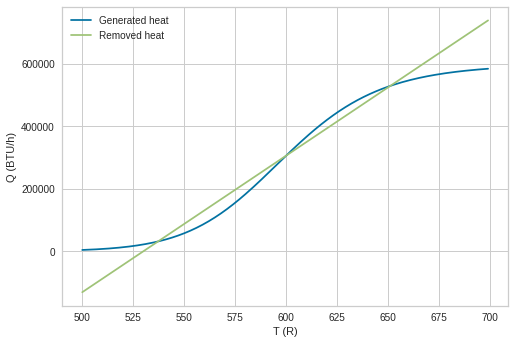

In [40]:
c.plot_van_heerden()

A figura acima ilustra que há três estados estacionários no processo, já que são três os pontos em que o calor gerado é igual ao calor removido.

Na classe `CSTR`, os set-points disponíveis para a malha de controle são os três estados estacionários (EE) apresentados acima (0, 1 ou 2). Devemos especificá-los por meio de uma array que contém os set-points de cada um dos instantes de amostragem, como definido abaixo:

In [41]:
ee_sp = np.zeros(c.nk)+2
ee_sp[c.nk//3:2*c.nk//3] = 1
ee_sp[2*c.nk//3:] = 0

O primeiro terço dos instantes foi atribuído ao EE 2, o segundo terço ao EE 1 e o último terço ao EE 0.

Rodando a simulação:

In [42]:
%time cstr_df = c.run(ee_sp = ee_sp)

CPU times: user 14.6 s, sys: 1.32 ms, total: 14.6 s
Wall time: 14.6 s


Visualizando o `DataFrame` resultante:

In [43]:
cstr_df

,V,Ca,T,Tj,Fi,Cai,Ti,Tji,F,Fj
2020-01-01 00:00:00,47.907364,0.102832,618.043292,644.506669,37.442594,0.527359,530.720437,529.215389,40.424206,56.363272
2020-01-01 00:02:00,48.027571,0.012988,660.714045,628.962426,39.817928,0.518470,529.597447,528.463495,40.353575,62.074107
2020-01-01 00:04:00,48.009576,0.018401,650.304199,649.328107,38.837262,0.503253,529.042725,529.692229,39.736943,34.381309
2020-01-01 00:06:00,48.030774,0.014865,649.396677,624.545179,39.196015,0.531621,529.800524,529.545161,39.330123,48.371887
2020-01-01 00:08:00,47.915912,0.146249,645.086185,645.103889,38.832328,0.520243,529.992058,529.673608,40.119190,49.925650
...,...,...,...,...,...,...,...,...,...,...
2020-01-04 23:50:00,48.095751,0.447706,538.153038,551.079341,40.387067,0.531211,529.396594,530.528229,40.431042,55.709553
2020-01-04 23:52:00,48.007236,0.545848,537.429504,528.033724,41.332021,0.527115,529.831818,530.770365,41.072331,48.530089
2020-01-04 23:54:00,48.148992,0.454554,537.788713,546.732878,40.904693,0.526377,530.032064,530.873587,42.097304,53.080465
2020-01-04 23:56:00,48.186044,0.506858,535.212929,529.440791,40.153002,0.505071,531.142794,530.466759,42.437083,57.833764


Visualizando a evolução temporal das variáveis de estado, de entrada e manipuladas, respectivamente:

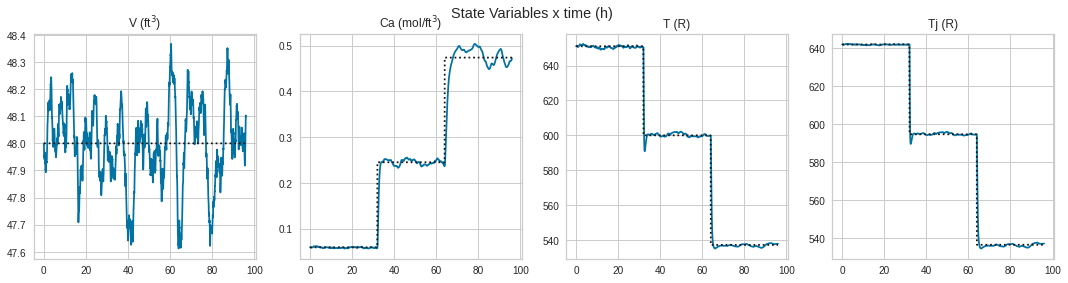

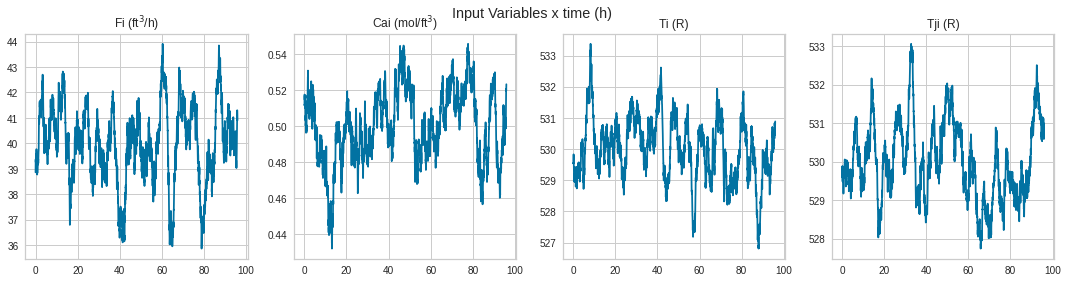

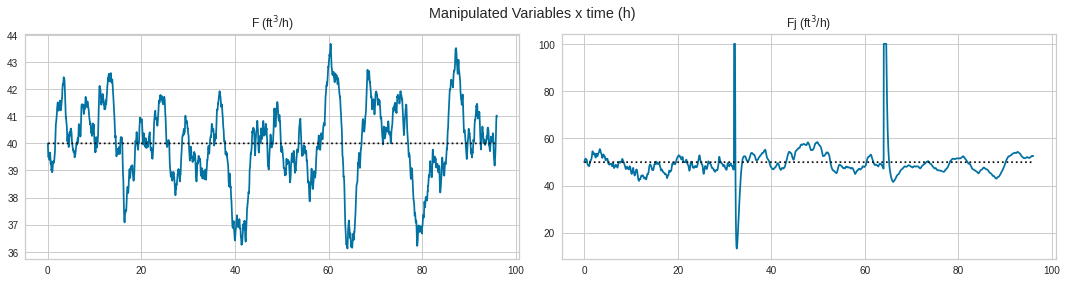

In [44]:
c.plot('x')
c.plot('u')
c.plot('m')

A separação entre os estados estacionários fica evidente nos gráficos de $C_A$, $T$ e $T_j$.

## Aplicação do $k$-means

Como no exemplo anterior, começemos gerando os gráficos de inércia e silhueta:

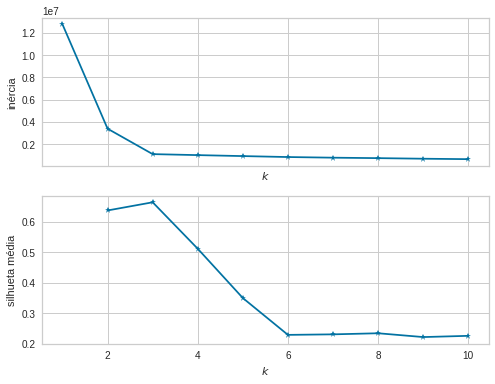

In [45]:
fig, ax = plt.subplots(2,1, figsize = (8,6), sharex=True)

plot_inercia_per_k(cstr_df, range(1,11), ax=ax[0])
plot_silhueta_per_k(cstr_df, range(2,11), ax=ax[1]);

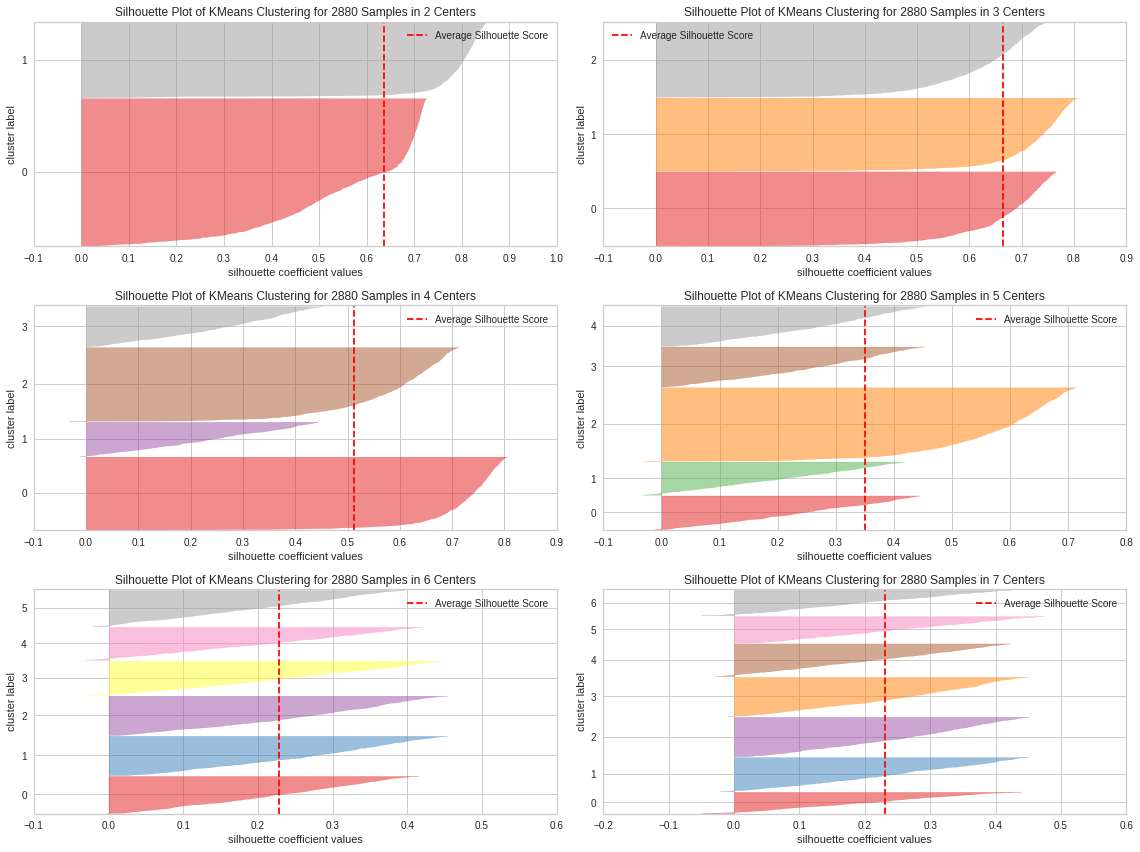

In [46]:
plot_silhueta(cstr_df, [2,3,4,5,6,7])

Em todos os gráficos, é evidente a maior adequação da escolha $k=3$.

Visualizando o espaço $C_A,T,T_j$, tanto com os rótulos verdadeiros quanto com os rótulos atribuídos pelo $k$-means:

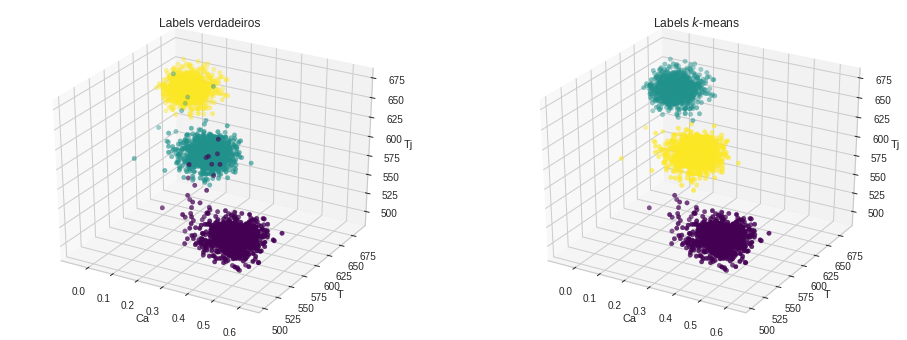

In [47]:
m = sklearn.cluster.KMeans(n_clusters=3)
m.fit(cstr_df)

fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'3d'}, figsize=(16,6))

colors = [ee_sp, m.labels_]
titles = ['Labels verdadeiros', 'Labels $k$-means']

for i in range(len(colors)):

    ax[i].scatter(cstr_df.loc[:,'Ca'], cstr_df.loc[:,'T'], cstr_df.loc[:,'Tj'],
                  c=colors[i], cmap='viridis')

    ax[i].set_title(titles[i])
    
    ax[i].set_xlabel('Ca')
    ax[i].set_ylabel('T')
    ax[i].set_zlabel('Tj')

Alguns pontos são enganosos e classificados incorretamente pelo $k$-means. Provavelmente correspondem ao transiente da troca de estados estacionários.

Como temos os labels verdadeiros para esse caso - que são os set-points especificados na simulação - é possível calcular as métricas homogeneidade, completude e medida V:

In [48]:
sklearn.metrics.homogeneity_completeness_v_measure(m.labels_, ee_sp)

(0.9694907702366826, 0.9694616695279418, 0.9694762196639337)

As métricas confirmam o bom desempenho verificado com as visualizações anteriores.

A metodologia apresentada pode ser utilizada, por exemplo, para gerar um cluster de dados para cada modo de operação no contexto do treinamento de modelos de detecção de falhas. O PCA é um caso de modelo que não conseguiria capturar a estrutura multimodal de dados contendo vários modos de operação. A estratégia poderia ser, portanto, gerar um modelo PCA para cada cluster e utilizar o $k$-means para determinar automaticamente, durante a operação, o estado estacionário em que o processo se encontra no momento. Você pode inclusive tentar implementar essa estratégia utilizando o modelo PCA da Aula 2 (para rodar uma simulação `CSTR` com desvios em variáveis de processo, especifique o argumento `faulty` do método `run` como `True`).

**Mão na massa!**

* Adicione o conjunto de dados [Mall Customer Segmentation Data](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python) ao notebook. 

* Efetue uma exploração inicial do conjunto (uma boa biblioteca para isso é a [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling), vale a pena usá-la).

* Aplique o modelo $k$-means para obter clusters de clientes de diferentes características. Identifique que tipos de clientes os clusters conseguem discriminar. 

Dica: nem todas as variáveis precisam ser utilizadas para que se atinja uma separação adequada e interpretável.

# Conclusão

Nesta aula aprendemos como resolver problemas de [clusterização](https://en.wikipedia.org/wiki/Cluster_analysis) utilizando o modelo [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering), aplicando aos casos de [segmentação de mercado](https://pt.wikipedia.org/wiki/Segmenta%C3%A7%C3%A3o_de_mercado) e identificação de [modos de operação em um reator químico](http://www.learncheme.com/simulations/kinetics-reactor-design/multiple-steady-states-in-cstr-with-heat-exchange).

É importante ressaltar que, apesar de a maior parte das aplicações de aprendizado de máquina ser de algoritmos supervisionados, a maioria dos dados disponíveis *não* possui rótulo. Daí a importância de dominar também metodologias não-supervisionadas, já que elas possibilitam a captura de padrões a partir da estrutura dos dados $X$ sem a necessidade da utilização de rótulos (conjuntos de saída $y$) que guiem o aprendizado.

É isso. Até a próxima!